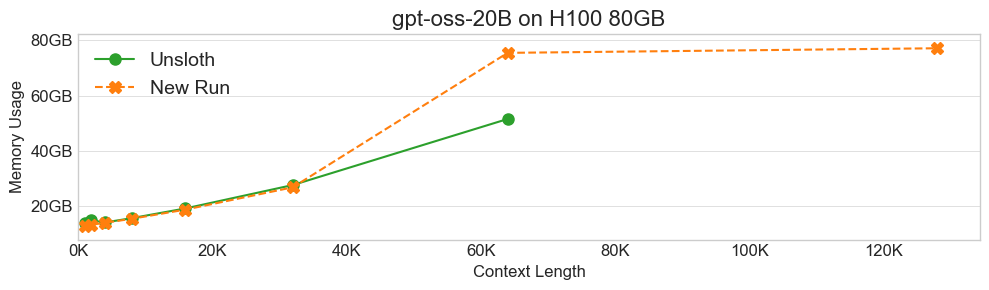

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import io
import pandas as pd
import numpy as np

# --- Data from both runs ---

# Data from your first message
data_string_1 = """
fr_gpt-oss_with_flex_65536	55376150528
fr_gpt-oss_with_flex_32768	29736370176
fr_gpt-oss_with_flex_16384	20645216256
fr_gpt-oss_with_flex_8192	16864051200
fr_gpt-oss_with_flex_4096	15207301120
fr_gpt-oss_with_flex_2048	16062939136
fr_gpt-oss_with_flex_1024	14827716608
"""

# Data from your second message
data_string_2 = """
fr_gpt-oss_with_flex_131072	82834161664
fr_gpt-oss_with_flex_65536	81049485312
fr_gpt-oss_with_flex_32768	28855566336
fr_gpt-oss_with_flex_16384	20192231424
fr_gpt-oss_with_flex_8192	16627073024
fr_gpt-oss_with_flex_4096	15073083392
fr_gpt-oss_with_flex_2048	14316011520
fr_gpt-oss_with_flex_1024	13959495680
"""

# --- Reusable function to process the data ---
def process_wandb_data(data_string):
    """Parses the raw string data into a clean DataFrame."""
    df = pd.read_csv(io.StringIO(data_string.strip()), sep='\t', header=None, names=['run', 'memory_bytes'])
    df['context_length_k'] = df['run'].str.split('_').str[-1].astype(int) / 1024
    df['memory_gb'] = df['memory_bytes'] / (1024**3)
    return df.sort_values('context_length_k')

# Process both datasets
df1 = process_wandb_data(data_string_1)
df2 = process_wandb_data(data_string_2)

# --- Create the plot ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 3))

# Plot data from the first run
ax.plot(df1['context_length_k'], df1['memory_gb'], marker='o', linestyle='-', color='#2ca02c', label='Unsloth', markersize=8)

# Plot data from the second run
ax.plot(df2['context_length_k'], df2['memory_gb'], marker='X', linestyle='--', color='#ff7f0e', label='New Run', markersize=8)


# --- Style the graph for clear comparison ---
ax.set_title('gpt-oss-20B on H100 80GB', fontsize=16)
ax.set_xlabel('Context Length', fontsize=12)
ax.set_ylabel('Memory Usage', fontsize=12)

# Format axes
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{int(round(y))}GB'))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x)}K'))
ax.tick_params(axis='both', which='major', labelsize=12)

# Set axis limits to encompass all data points
min_gb = min(df1['memory_gb'].min(), df2['memory_gb'].min())
max_gb = max(df1['memory_gb'].max(), df2['memory_gb'].max())
ax.set_ylim(bottom=min_gb - 5, top=max_gb + 5)
ax.set_xlim(left=0)


# Add a legend to distinguish the lines
ax.legend(fontsize=14, frameon=False, loc='upper left', ncol=1)

# Make the grid lighter
ax.yaxis.grid(True, which='major', linestyle='-', linewidth=0.5, color='lightgray')
ax.xaxis.grid(False)

plt.tight_layout()
plt.savefig('gpt_oss_memory_comparison.pdf', format='pdf')
plt.show()

In [ ]:
# Save to pdf

<Figure size 640x480 with 0 Axes>